In [74]:
import glob
import numpy as np
import math
import cv2
from cv2 import aruco
import os
import json
import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import pprint as pp

In [75]:
def getVectorFromDic(idx0,idx1):
    return marker_dict[idx0]["tvec"] - marker_dict[idx1]["tvec"]

# idx0: origin
def getAngleFromDic(idx1,idx0,idx2):
    return getAngle(getVectorFromDic(idx2,idx0),getVectorFromDic(idx1,idx0))

def getDistanceFromDic(idx0,idx1):
     return np.linalg.norm(getVectorFromDic(idx0,idx1))
def getJointVec(arr,joint_num):
    return np.array(arr[joint_num*4:joint_num*4+3])

def normalization(vec):
    return vec/np.linalg.norm(vec)
def getSize(vec):
    return np.linalg.norm(vec)

def dotproduct(v1, v2):
    return sum((a*b) for a, b in zip(v1, v2))

def length(v):
    return math.sqrt(dotproduct(v, v))

def getAngle(v1, v2):
    return math.degrees(math.acos(dotproduct(v1, v2) / (length(v1) * length(v2))))
def vec_norm(vec):
    return vec/np.linalg.norm(vec)

def getUpVectorFromRvecs(idx):
    rtx = cv2.Rodrigues(rvecs[idx])[0]
    return rtx.T[2]

# Get Camera Parameters

In [76]:
parameter_dir="./camera_parameters"

#load xml file
camera_parameters = {}
# camera_idxs = ["18284509","18284511","18284512"]
camera_idxs = ["18284509"]

parameter_types = ["CameraMatrix","Intrinsics","Distortion"]


for camera_idx in camera_idxs:
    fileToLoad = os.path.join(parameter_dir,camera_idx+".xml")
    fs = cv2.FileStorage(fileToLoad, cv2.FILE_STORAGE_READ)
    _camera_parameter = {}
    for parameter_type in parameter_types:
        _camera_parameter[parameter_type] = fs.getNode(parameter_type).mat()
        camera_parameters[camera_idx] = _camera_parameter

#3d points to image (2nd image)
extri = [0]*3
intri  = [0]*3
dist = [0]*3

for i in range(len(camera_idxs)):
    rotation_matrix = camera_parameters[camera_idxs[i]][parameter_types[0]][:,0:3]
    rvec,_ = cv2.Rodrigues(rotation_matrix)
    tvec = camera_parameters[camera_idxs[i]][parameter_types[0]][:,3]
    
    extri[i] = camera_parameters[camera_idxs[i]][parameter_types[0]]
    intri[i] = camera_parameters[camera_idxs[i]][parameter_types[1]]
    dist[i] = camera_parameters[camera_idxs[i]][parameter_types[2]]

In [77]:
camera_index = 0

mtx = camera_parameters[camera_idxs[camera_index]][parameter_types[1]]
dist = camera_parameters[camera_idxs[camera_index]][parameter_types[2]]

In [78]:
aruco_dict = aruco.Dictionary_get(aruco.DICT_4X4_250)
length_of_axis = 0.09
markerLength = 0.18

white_background  = np.full((1024, 1280, 3),255)
# white_background = (np.float32(white_background), cv2.COLOR_RGB2GRAY)


image_data = "./img/000000000000_rendered.png"
frame  = cv2.imread(image_data,cv2.IMREAD_UNCHANGED)
frame = cv2.cvtColor(frame, cv2.COLOR_RGB2BGR)

gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
parameters =  aruco.DetectorParameters_create()
corners, ids, rejectedImgPoints = aruco.detectMarkers(gray, aruco_dict, parameters=parameters)


frame_markers = aruco.drawDetectedMarkers(frame.copy(), corners, ids)
# frame_markers = aruco.drawDetectedMarkers(white_background.copy(), corners, ids)

rvecs,tvecs, objPts = aruco.estimatePoseSingleMarkers(corners, markerLength , mtx, dist)
imaxis = aruco.drawDetectedMarkers(frame.copy(), corners, ids)
# imaxis = aruco.drawDetectedMarkers(white_background, corners, ids)


for i in range(len(rvecs)):
    imaxis = aruco.drawAxis(imaxis, mtx, dist, rvecs[i], tvecs[i], length_of_axis)


# Marker data to dictionary
marker_dict = {}

for idx,marker_index in enumerate(ids):
    marker_index = marker_index[0]
    _vecs = {}
    _vecs["rvec"] = rvecs[idx][0]
    _vecs["tvec"] = tvecs[idx][0]
    _vecs["corner"] = corners[idx][0]
    marker_dict[marker_index] = _vecs
print("tvecs and rvecs for each marker\n")
# pp.pprint(marker_dict)


tvecs and rvecs for each marker



<Figure size 432x288 with 0 Axes>

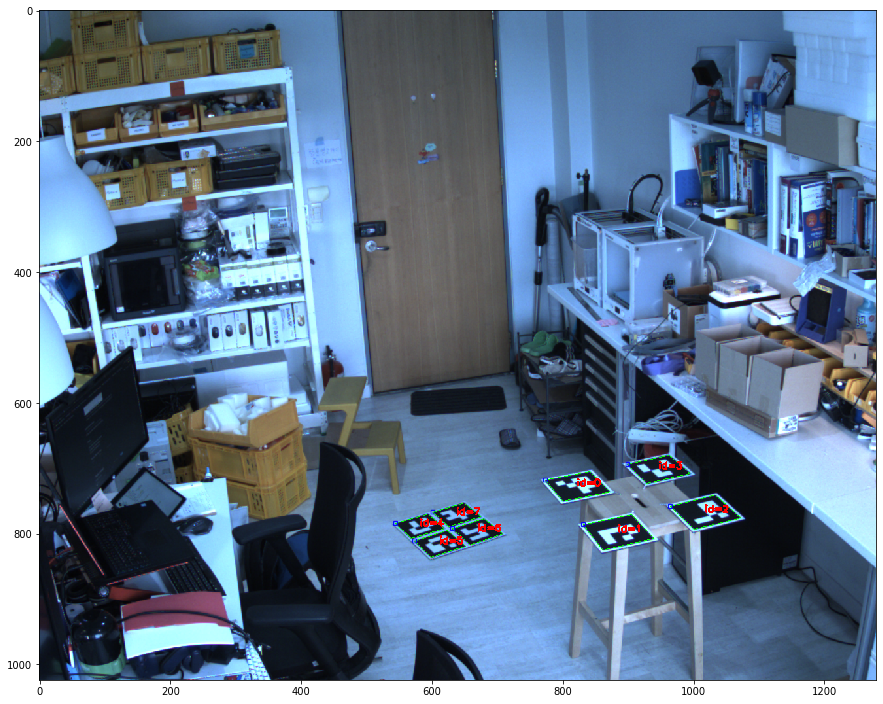

In [79]:
# def annotateDistanceFromDic(idx0,idx1):

def getCenterOnImageFromDic(idx):
    return np.average(marker_dict[idx]["corner"],axis = 0)

plt.figure()
plt.figure(figsize=(15,15))
plt.imshow(imaxis)
plt.imshow(frame_markers)

plt.show()

<Figure size 432x288 with 0 Axes>

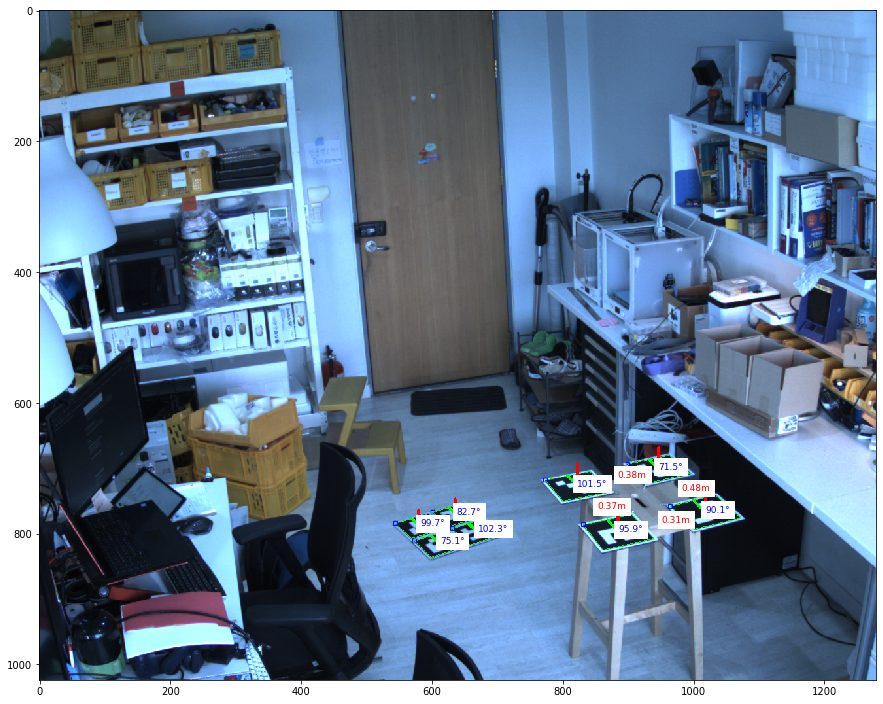

In [80]:
# def annotateDistanceFromDic(idx0,idx1):

def getCenterOnImageFromDic(idx):
    return np.average(marker_dict[idx]["corner"],axis = 0)

plt.figure()
plt.figure(figsize=(15,15))


#Actual Distance: 0.32m 0.36m
for idx0,idx1 in [[0,1],[1,2],[2,3],[3,0]]:
    cen_x, cen_y = np.average([getCenterOnImageFromDic(idx0),getCenterOnImageFromDic(idx1)],axis = 0)
    distance = getDistanceFromDic(idx0,idx1)
    text = plt.text(int(cen_x), int(cen_y), "{:.2f}m".format(distance), fontsize=9,color = "red")
    text.set_bbox(dict(facecolor='white', alpha=1, edgecolor='white'))
    

for idx1,idx0,idx2 in [[0,1,2],[1,2,3],[2,3,0],[3,0,1]]:
    x,y = getCenterOnImageFromDic(idx0)
    angle = getAngleFromDic(idx1,idx0,idx2)
    text = plt.text(int(x), int(y), "{:.1f}°".format(angle), fontsize=9,color = "blue")
    text.set_bbox(dict(facecolor='white', alpha=1, edgecolor='white'))

    

for idx1,idx0,idx2 in [[4,5,6],[5,6,7],[6,7,4],[7,4,5]]:
    x,y = getCenterOnImageFromDic(idx0)
    angle = getAngleFromDic(idx1,idx0,idx2)
    text = plt.text(int(x), int(y), "{:.1f}°".format(angle), fontsize=9,color = "blue")
    text.set_bbox(dict(facecolor='white', alpha=1, edgecolor='white'))


plt.imshow(imaxis)
plt.show()

In [81]:
def upVectorFromDic(idx0,idx1,idx2):
    vec = np.cross(getVectorFromDic(idx0,idx1),getVectorFromDic(idx2,idx1))
    return  vec/np.linalg.norm(vec)

In [82]:
print(getAngle(upVectorFromDic(5,4,7),upVectorFromDic(7,6,5)))
print(getAngle(upVectorFromDic(1,0,3),upVectorFromDic(0,3,2)))
print(getAngle(upVectorFromDic(1,0,3),upVectorFromDic(5,4,7)))

4.627488872281969
6.528111153490576
7.0919069192786655


In [83]:
upVectorFromDic(5,4,7)

array([-0.06244402, -0.97513376, -0.21263794])

In [84]:
cv2.Rodrigues(rvecs[0])[0].shape
cv2.Rodrigues(rvecs[0])[0].shape

(3, 3)

In [85]:
pp.pprint(cv2.Rodrigues(rvecs[0])[0]*np.array([1,0,0]).T)
pp.pprint(cv2.Rodrigues(rvecs[1])[0]*np.array([1,0,0]).T)
up_vector = (cv2.Rodrigues(rvecs[0])[0]*np.array([0,0,1])).T[2]
print(up_vector)
vec1 = vec_norm(up_vector)

array([[ 0.88434125, -0.        , -0.        ],
       [-0.20501784, -0.        , -0.        ],
       [ 0.41941416,  0.        , -0.        ]])
array([[ 0.87985432, -0.        , -0.        ],
       [-0.20108534, -0.        , -0.        ],
       [ 0.43060546,  0.        , -0.        ]])
[-0.06857677 -0.94571236 -0.31768752]


In [86]:
floor_idx = [4,5,6,7]
data = []
for i in floor_idx:
    data.append(getUpVectorFromRvecs(i))
floor_up_vector_average = np.average(np.array(data),axis=0)

In [87]:
##Experiment01
floor_up_vector_average = [-0.06778487, -0.94893388, -0.30810663]
floor_up_vector_cross = [-0.02393431, -0.97448589, -0.223169  ]
floor_up_vector_cross_with_distance = [-0.30037252, -0.87461913, -0.38054926]

In [110]:
print(getAngle(floor_up_vector_average,floor_up_vector_cross))
print(getAngle(floor_up_vector_average,floor_up_vector_cross_with_distance))
print(getAngle(floor_up_vector_cross,floor_up_vector_cross_with_distance))

5.671464763049447
14.63246569198978
19.1923972641157


In [88]:
vec = [upVectorFromDic(6,5,4),upVectorFromDic(7,6,5),upVectorFromDic(4,7,6),upVectorFromDic(5,4,7)]
floor_up_vector_cross = vec_norm(np.average(np.array(vec),axis=0))
floor_up_vector_cross

array([-0.02393431, -0.97448589, -0.223169  ])

In [107]:
# Accurate Value= 75 cm
print(np.dot(getVectorFromDic(0,4),floor_up_vector_cross))

0.675166307221762


# Marker with distance apart

tvecs and rvecs for each marker



<Figure size 432x288 with 0 Axes>

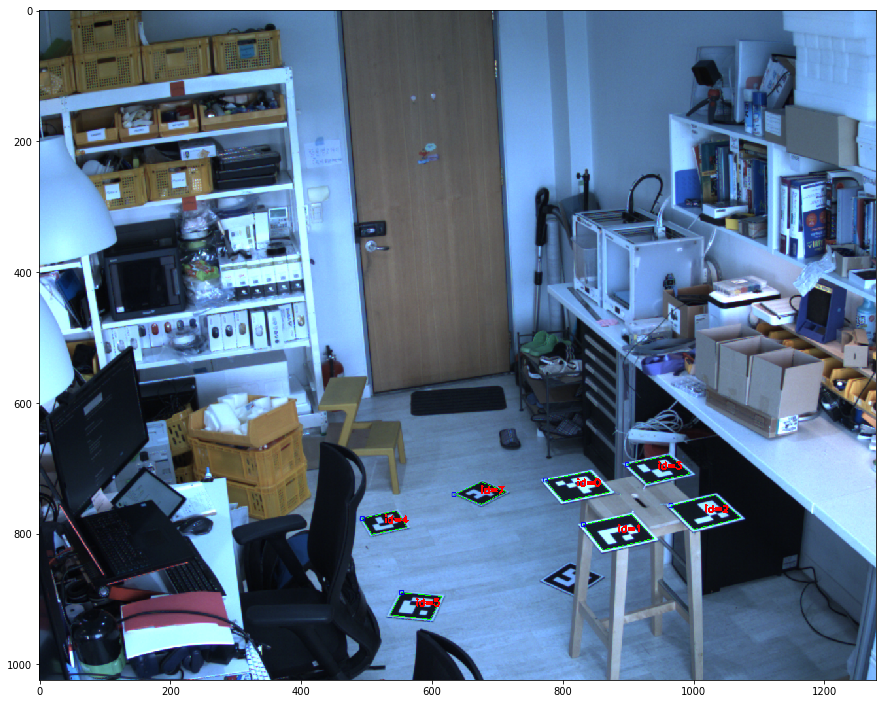

In [173]:
aruco_dict = aruco.Dictionary_get(aruco.DICT_4X4_250)
length_of_axis = 0.09
markerLength = 0.18

white_background  = np.full((1024, 1280, 3),255)
# white_background = (np.float32(white_background), cv2.COLOR_RGB2GRAY)


image_data = "./img/000000000021_rendered.png"
frame  = cv2.imread(image_data,cv2.IMREAD_UNCHANGED)
frame = cv2.cvtColor(frame, cv2.COLOR_RGB2BGR)

gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
parameters =  aruco.DetectorParameters_create()
corners, ids, rejectedImgPoints = aruco.detectMarkers(gray, aruco_dict, parameters=parameters)


frame_markers = aruco.drawDetectedMarkers(frame.copy(), corners, ids)
# frame_markers = aruco.drawDetectedMarkers(white_background.copy(), corners, ids)

rvecs,tvecs, objPts = aruco.estimatePoseSingleMarkers(corners, markerLength , mtx, dist)
# imaxis = aruco.drawDetectedMarkers(frame.copy(), corners, ids)
# imaxis = aruco.drawDetectedMarkers(white_background, corners, ids)


for i in range(len(rvecs)):
    imaxis = aruco.drawAxis(imaxis, mtx, dist, rvecs[i], tvecs[i], length_of_axis)


# Marker data to dictionary
marker_dict = {}

for idx,marker_index in enumerate(ids):
    marker_index = marker_index[0]
    _vecs = {}
    _vecs["rvec"] = rvecs[idx][0]
    _vecs["tvec"] = tvecs[idx][0]
    _vecs["corner"] = corners[idx][0]
    marker_dict[marker_index] = _vecs
print("tvecs and rvecs for each marker\n")
# pp.pprint(marker_dict)
plt.figure()
plt.figure(figsize=(15,15))
plt.imshow(imaxis)
plt.imshow(frame_markers)

plt.show()

In [174]:
up_vector = upVectorFromDic(5,4,7)

array([-0.30037252, -0.87461913, -0.38054926])